# Exploratory Data Analysis (EDA)

## Step 1 — Target Variable Analysis

**Objective:**
Understand the statistical behavior of the target variable (`SalePrice`) in order to support modeling decisions later in the pipeline.

At this stage:
- No models are trained
- No transformations are applied permanently
- The test dataset is not used for statistical inference


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

pd.set_option("display.max_columns", None)
sns.set_style("whitegrid")


In [3]:
train_path = "../data/raw/train.csv"
test_path = "../data/raw/test.csv"

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)


Train shape: (1460, 81)
Test shape: (1459, 80)


### Train vs Test Data Usage

The training dataset is used for:
- Statistical analysis
- Distribution inspection
- Decision-making regarding transformations

The test dataset is used **only** for:
- Structural validation (columns, data types, missing values)

This separation is critical to prevent **data leakage**.


In [4]:
target = "SalePrice"

train_df[target].describe()


count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

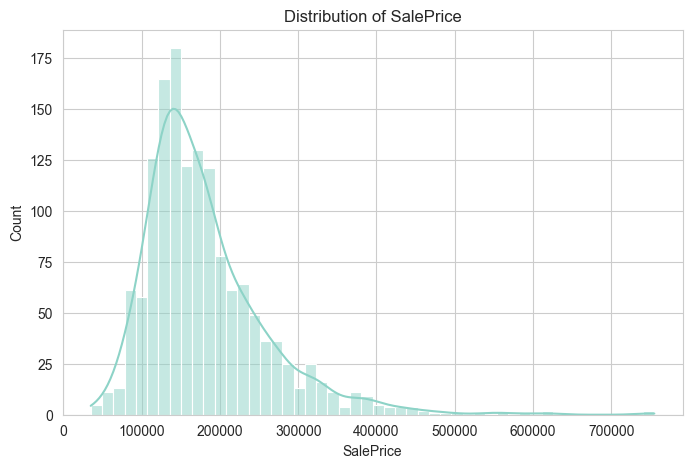

In [10]:
plt.figure(figsize=(8, 5))
sns.histplot(train_df[target], bins=50, kde=True)
plt.title("Distribution of SalePrice")
plt.show()


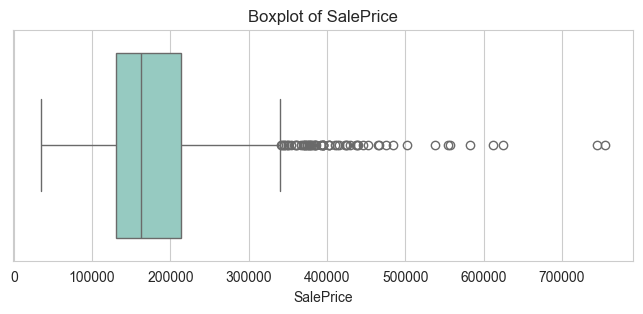

In [11]:
plt.figure(figsize=(8, 3))
sns.boxplot(x=train_df[target])
plt.title("Boxplot of SalePrice")
plt.show()


### QQ-Plot Analysis

A QQ-Plot (Quantile-Quantile Plot) compares the quantiles of the observed data
against the quantiles of a theoretical normal distribution.

Interpretation guidelines:
- Points close to the diagonal line → approximately normal distribution
- Curvature or tail deviations → skewness or heavy tails


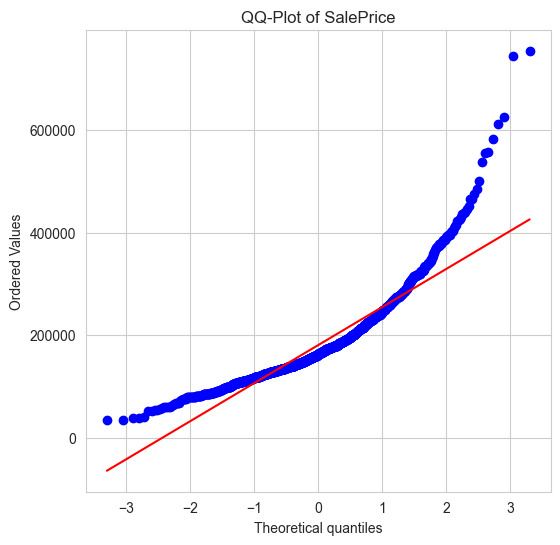

In [12]:
plt.figure(figsize=(6, 6))
stats.probplot(train_df[target], dist="norm", plot=plt)
plt.title("QQ-Plot of SalePrice")
plt.show()


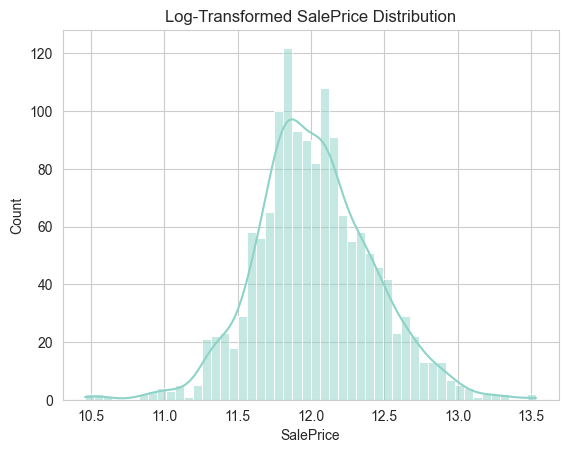

In [13]:
log_saleprice = np.log1p(train_df[target])
sns.histplot(log_saleprice, bins=50, kde=True)
plt.title("Log-Transformed SalePrice Distribution")
plt.show()


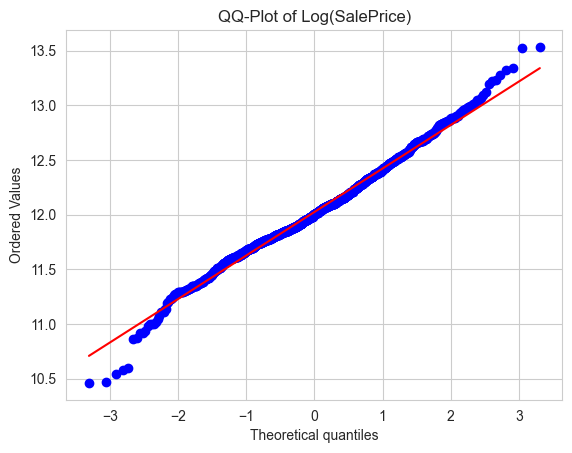

In [14]:
stats.probplot(log_saleprice, dist="norm", plot=plt)
plt.title("QQ-Plot of Log(SalePrice)")
plt.show()


### Technical Decision

The original target variable (`SalePrice`) exhibits strong positive skewness
and heavy tails.

A logarithmic transformation significantly improves symmetry and normality.
Therefore, a log transformation of the target will be **considered during the modeling phase**.


## Step 2 — Semantic Feature Typing

Before any preprocessing or modeling, features must be classified according
to their semantic meaning.

This prevents:
- Incorrect encodings
- Loss of ordinal information
- Invalid statistical assumptions


In [15]:
train_df.dtypes.value_counts()


object     43
int64      35
float64     3
Name: count, dtype: int64

In [16]:
numeric_features = train_df.select_dtypes(include=["int64", "float64"]).columns.tolist()
numeric_features.remove("SalePrice")

categorical_features = train_df.select_dtypes(include=["object"]).columns.tolist()

len(numeric_features), len(categorical_features)

(37, 43)

### Ordinal Features

Ordinal features represent categories with a **natural order**, but without
a guaranteed linear distance between levels.

Examples:
- Quality ratings (Poor → Fair → Good → Excellent)
- Condition scores
- Finish levels

Treating ordinal features as nominal categories may cause information loss.


In [17]:
ordinal_features = [
    "OverallQual",
    "OverallCond",
    "ExterQual",
    "ExterCond",
    "BsmtQual",
    "BsmtCond",
    "BsmtExposure",
    "BsmtFinType1",
    "BsmtFinType2",
    "HeatingQC",
    "KitchenQual",
    "FireplaceQu",
    "GarageQual",
    "GarageCond",
    "PoolQC",
    "Fence"
]

len(ordinal_features)

16

In [18]:
nominal_categorical_features = [
    col for col in categorical_features if col not in ordinal_features
]

len(nominal_categorical_features)

29

### Temporal Features

Temporal features represent time-related information and should not be used
in raw form during modeling.

They will be transformed into derived features such as:
- Property age
- Time since last renovation


In [19]:
temporal_features = [
    "YearBuilt",
    "YearRemodAdd",
    "YrSold"
]

temporal_features


['YearBuilt', 'YearRemodAdd', 'YrSold']

## Step 2.8 — Missing Values: Semantic Analysis

Missing values in this dataset do not always represent unknown data.
In many cases, they indicate the **absence of a specific feature**.

Correctly interpreting missing values is critical to avoid
introducing noise or bias during preprocessing.


In [20]:
missing_counts = train_df.isna().sum()
missing_counts = missing_counts[missing_counts > 0].sort_values(ascending=False)

missing_counts.head(20)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
dtype: int64

### Types of Missing Values

Missing values are classified into two categories:

1. Structural absence
   - The feature does not exist for the property
   - Example: No garage, no pool, no basement

2. True missing values
   - The feature exists, but the value is unknown
   - Example: Lot frontage length


In [21]:
structural_missing_features = [
    "Alley",
    "PoolQC",
    "Fence",
    "MiscFeature",
    "FireplaceQu",
    "GarageType",
    "GarageFinish",
    "GarageQual",
    "GarageCond",
    "BsmtQual",
    "BsmtCond",
    "BsmtExposure",
    "BsmtFinType1",
    "BsmtFinType2"
]

len(structural_missing_features)


14

In [22]:
true_missing_features = [
    "LotFrontage",
    "MasVnrArea",
    "MasVnrType",
    "Electrical"
]

true_missing_features


['LotFrontage', 'MasVnrArea', 'MasVnrType', 'Electrical']

### Technical Decision

Structural missing values will be explicitly encoded to represent
feature absence.

True missing values will be imputed using strategies learned
exclusively from the training dataset.


## Step 3 — Outlier Analysis

Outliers can significantly impact model performance, especially
in regression problems.

However, removing outliers without domain justification may
harm generalization and introduce bias.


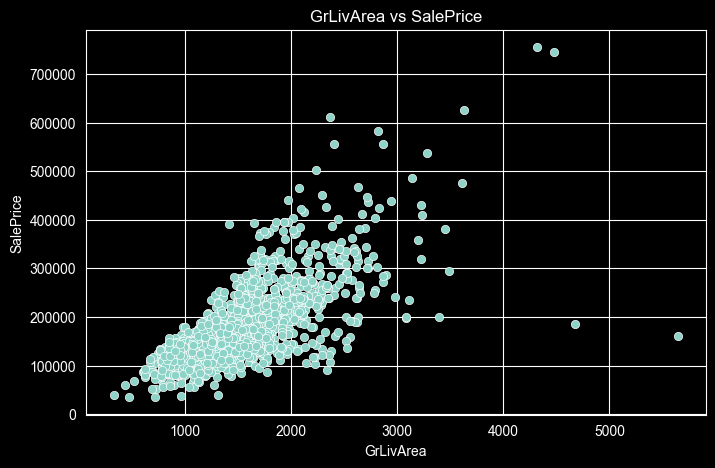

In [23]:
plt.figure(figsize=(8, 5))
sns.scatterplot(
    x=train_df["GrLivArea"],
    y=train_df["SalePrice"]
)
plt.title("GrLivArea vs SalePrice")
plt.show()

### Outlier Interpretation

Some properties exhibit very large living areas combined with
unexpectedly low sale prices.

These observations may represent rare but valid cases rather than
data errors. Therefore, no outliers are removed at this stage.


## Final Decisions — Phase 1

- The target variable shows strong right skewness.
  A log transformation will be considered during modeling.

- Features were semantically classified into:
  - Numerical
  - Ordinal
  - Nominal categorical
  - Temporal

- Missing values were analyzed semantically and classified into:
  - Structural absence
  - True missing values

- No outliers were removed to avoid unintended bias.
